In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_squared_error

warnings.simplefilter(action='ignore', category=FutureWarning)
plt.style.use('fivethirtyeight')

## Ingest Historical Data from the Panama Canal Authority

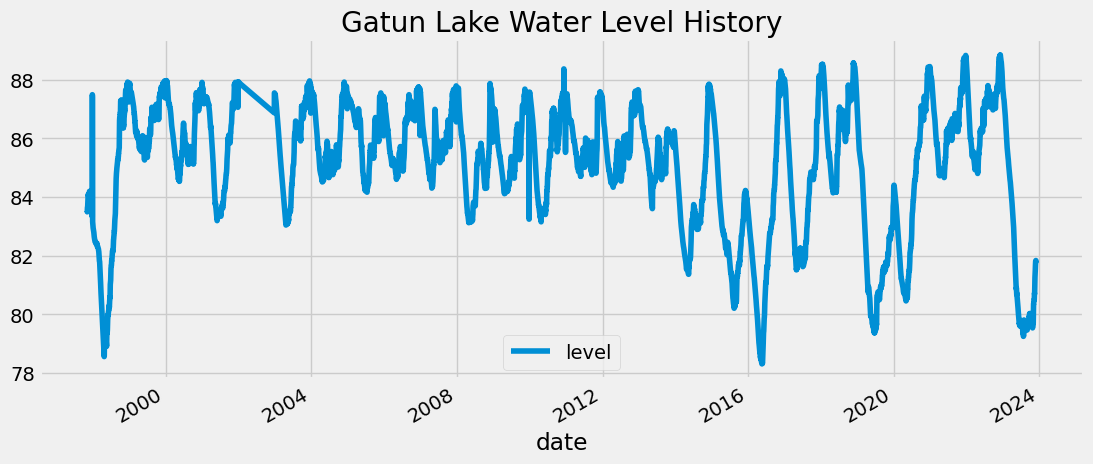

In [2]:
# Read Panama Canal historical data
historical = pd.read_csv('https://evtms-rpts.pancanal.com/eng/h2o/Download_Gatun_Lake_Water_Level_History.csv', 
                        parse_dates=['date'], index_col='date', na_values=['0'], 
                        names=['date', 'level'], skiprows=1)
historical = historical.dropna()
historical.loc['11-01-1997':].plot(figsize=(12, 5), title='Gatun Lake Water Level History');

## Ingest ENSO Forecasts from IRI
- Uses an even blend of the dynamical and statistical model consensus
- Forecast available out to ~8 months

In [3]:
enso = pd.read_html('https://iri.columbia.edu/our-expertise/climate/forecasts/enso/current/?enso_tab=enso-sst_table')
enso_forecast = enso[4]
enso_mean = enso_forecast.iloc[-1:]
enso_mean.columns = enso_mean.columns.droplevel(0)

# Rename columns NDJ as December, DFJ as January, etc.
enso_mean = enso_mean.copy()

enso_mean.rename(columns={'NDJ': 12, 'DJF': 1, 'JFM': 2, 'FMA': 3, 'MAM': 4, 'AMJ': 5,
                          'MJJ': 6, 'JJA': 7, 'JAS': 8, 'ASO': 9, 'SON': 10, 'OND': 11},
                          inplace=True)

# Reset and delete index
enso_mean.reset_index(inplace=True)
enso_mean.drop(columns=['index'], inplace=True)
enso_mean = enso_mean.T
enso_mean.columns = enso_mean.iloc[0]
enso_mean = enso_mean.iloc[1:]

# Rename Average, All models column to average
enso_mean.rename(columns={'Average, All models': 'average'}, inplace=True)

# Convert to average column to float
enso_mean['average'] = enso_mean['average'].astype(float)

enso_mean


Model,average
12,1.897
1,1.839
2,1.646
3,1.351
4,0.943
5,0.577
6,0.246
7,0.010
8,-0.137


## Plot Panama Canal Authority Forecast
- Provided for reference
- Prediction made for ~2 months into the future

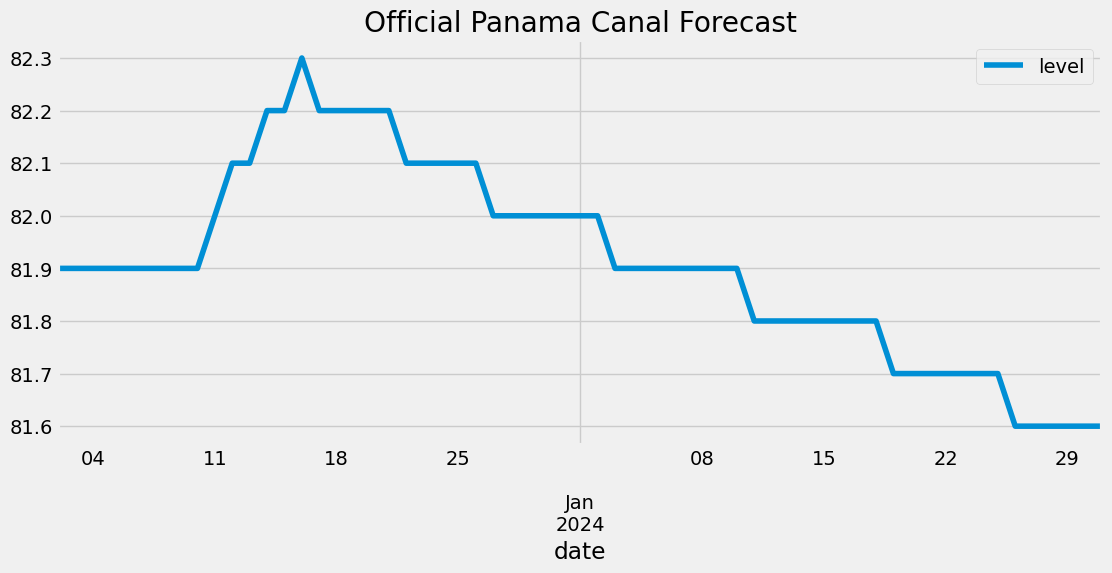

In [4]:
# Read Panama Canal forecast data
forecast = pd.read_csv('https://evtms-rpts.pancanal.com/eng/h2o/Gatun_Water_Level_Projection.csv', 
                        skiprows=3, parse_dates=['date'], index_col='date', usecols=['date', 'level'],
                        names=['date', 'level',])

forecast = forecast.sort_values(by='date')
forecast.plot(title='Official Panama Canal Forecast', figsize=(12, 5));



## Merge water level history with ENSO history

In [5]:
# Read nino12_daily and nino34_daily data
nino34 = pd.read_csv('nino34_daily.csv', parse_dates=['date'], index_col='date', names=['date', 'nino34'],
                     skiprows=1)
nino12 = pd.read_csv('nino12_daily.csv', parse_dates=['date'], index_col='date', names=['date', 'nino12'],
                     skiprows=1)

# Merge nino12 and nino34 data
nino = pd.merge(nino12, nino34, left_index=True, right_index=True)

# Merge nino and historical data
df = pd.merge(historical, nino, left_index=True, right_index=True)
df

,level,nino12,nino34
date,,,
1981-09-01,86.67,0.07,-0.06
1981-09-02,86.65,0.13,-0.07
1981-09-03,86.67,0.21,-0.11
1981-09-04,86.55,-0.09,-0.30
1981-09-05,86.49,-0.35,-0.35
...,...,...,...
2023-11-18,81.26,1.82,2.05
2023-11-19,81.32,1.89,2.08
2023-11-20,81.34,1.85,2.13


## Engineer additional input features for possible inclusion
- Time lags of water levels
- Rolling means for trends
- Day of year to capture seasonality

In [18]:
# Add water level time lagging
def add_lags(df, n_days):
    df = df.copy()
    target_map = df['level'].to_dict()
    df[f'level_lag{n_days}'] = (df.index - pd.Timedelta(days=n_days)).map(target_map)
    df['rolling_mean_120'] = df['level'].rolling(120).mean()
    df['rolling_mean_180'] = df['level'].rolling(180).mean()
    df['rolling_mean_240'] = df['level'].rolling(240).mean()
    return df

# Create time series features
def create_features(df):
    df = df.copy()
    df['dayofyear'] = df.index.dayofyear
    df['year'] = df.index.year
    return df

water_level_lags = [7, 14, 30, 60, 120, 180, 240]

for n_days in water_level_lags:
    df = add_lags(df, n_days)

df = create_features(df)

# Drop rows with NaN values
df.dropna(inplace=True)

df.tail()


,level,nino12,nino34,level_lag7,rolling_mean_120,rolling_mean_180,rolling_mean_240,level_lag14,level_lag30,level_lag60,level_lag120,level_lag180,level_lag240,dayofyear,isFuture,year
date,,,,,,,,,,,,,,,,
2023-11-18,81.26,1.82,2.05,80.49,79.805083,79.810278,80.471875,80.35,79.64,79.83,79.35,80.63,84.20,322,False,2023
2023-11-19,81.32,1.89,2.08,80.70,79.821417,79.814333,80.459958,80.35,79.62,79.89,79.36,80.59,84.18,323,False,2023
2023-11-20,81.34,1.85,2.13,80.71,79.838250,79.818778,80.448292,80.44,79.63,79.93,79.32,80.54,84.14,324,False,2023
2023-11-21,81.48,1.95,2.15,80.69,79.856583,79.824222,80.437417,80.44,79.65,79.93,79.28,80.50,84.09,325,False,2023
2023-11-22,81.63,2.10,2.19,80.74,79.876500,79.830611,80.427333,80.47,79.62,79.90,79.24,80.48,84.05,326,False,2023


## Define features and target for the model

In [39]:
FEATURES = ['dayofyear', 'nino12', 'nino34',
            'rolling_mean_120', 'rolling_mean_180', 'rolling_mean_240']
TARGET = 'level'

## Hyperparameter Tuning

In [40]:
# best_params = []
# best_score = []
# best_estimator = []
# train_score = []
# test_score = []

# tss = TimeSeriesSplit(n_splits=5, test_size=365 * 5, gap=1)

# for train_idx, val_idx in tss.split(df):
#     train = df.iloc[train_idx]
#     test = df.iloc[val_idx]

#     train = create_features(train)
#     test = create_features(test)

#     X_train = train[FEATURES]
#     Y_train = train[TARGET]

#     X_test = test[FEATURES]
#     Y_test = test[TARGET]

#     # search for ideal hyperparameters
#     reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50,
#                            random_state=42, learning_rate=0.01, max_depth=6,)
#     param_grid = {'n_estimators': [100, 200, 500,],
#                   'learning_rate': [0.01, 0.1, 0.5],
#                   'gamma': [0, 0.1, 0.5],
#                   'max_depth': [3, 4, 5,]}
#     grid = GridSearchCV(reg, param_grid, cv=5)
#     grid.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_test, Y_test)], verbose=100)
#     best_params.append(grid.best_params_)
#     best_score.append(grid.best_score_)
#     best_estimator.append(grid.best_estimator_)
#     train_score.append(grid.score(X_train, Y_train))
#     test_score.append(grid.score(X_test, Y_test))
#     print(grid.best_params_)
#     print(grid.best_score_)
#     print(grid.best_estimator_)
#     print(grid.score(X_train, Y_train))
#     print(grid.score(X_test, Y_test))

[0]	validation_0-rmse:84.45418	validation_1-rmse:83.89976


[99]	validation_0-rmse:31.20932	validation_1-rmse:30.68799
[0]	validation_0-rmse:84.45538	validation_1-rmse:83.90095
[99]	validation_0-rmse:31.27342	validation_1-rmse:30.75703
[0]	validation_0-rmse:84.45457	validation_1-rmse:83.90014
[99]	validation_0-rmse:31.22449	validation_1-rmse:30.72278
[0]	validation_0-rmse:84.45492	validation_1-rmse:83.90049
[99]	validation_0-rmse:31.26021	validation_1-rmse:30.73973
[0]	validation_0-rmse:84.45583	validation_1-rmse:83.90140
[99]	validation_0-rmse:31.30188	validation_1-rmse:30.77944
[0]	validation_0-rmse:84.45418	validation_1-rmse:83.89976
[100]	validation_0-rmse:30.89713	validation_1-rmse:30.37648
[199]	validation_0-rmse:11.42794	validation_1-rmse:11.01146
[0]	validation_0-rmse:84.45538	validation_1-rmse:83.90095
[100]	validation_0-rmse:30.96134	validation_1-rmse:30.44558
[199]	validation_0-rmse:11.47221	validation_1-rmse:11.17203
[0]	validation_0-rmse:84.45457	validation_1-rmse:83.90014
[100]	validation_0-rmse:30.91218	validation_1-rmse:30.41086

In [41]:
#print(best_params)
#print(best_score)
#print(best_estimator)
#print(train_score)
#print(test_score)


## Train model on the full dataset

In [50]:
df = create_features(df)

X_all = df[FEATURES]
y_all = df[TARGET]

model = xgb.XGBRegressor(n_estimators=100, 
                         max_depth=4, 
                         learning_rate=0.1,
                         gamma=0.5, 
                         random_state=42,
                         early_stopping_rounds=50,)

model.fit(X_all, y_all,
          eval_set=[(X_all, y_all)],
          verbose=100)                         

[0]	validation_0-rmse:76.35971


[99]	validation_0-rmse:0.46408


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.5, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

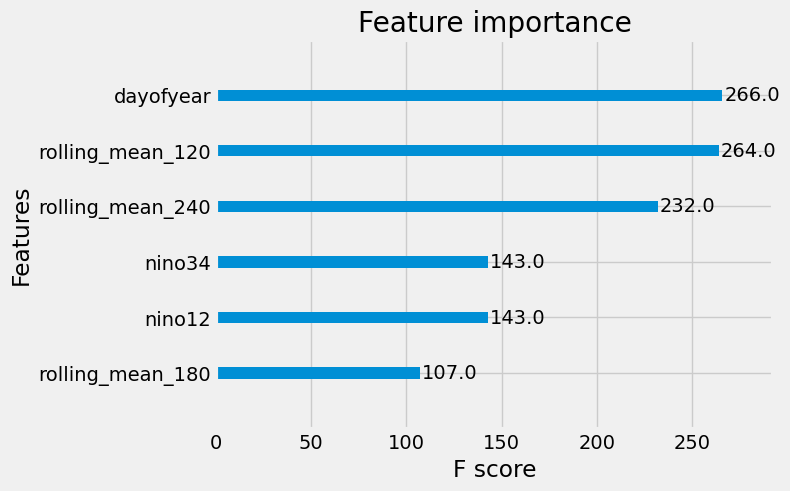

In [51]:
# Plot feature importances
xgb.plot_importance(model)
plt.show()



## Build prediction dataframes

In [52]:
# get today's date in pandas timestamp format in YYYY-MM-DD
today = pd.Timestamp.today().strftime('%Y-%m-%d')

future = pd.date_range('2023-11-23', periods=240, freq='D')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])

# Create features for future data
df_and_future = create_features(df_and_future)

df_and_future

,level,nino12,nino34,level_lag7,rolling_mean_120,rolling_mean_180,rolling_mean_240,level_lag14,level_lag30,level_lag60,level_lag120,level_lag180,level_lag240,dayofyear,isFuture,year
1982-12-25,87.24,3.37,2.58,85.98,86.037917,85.763833,85.535042,86.21,86.42,86.42,85.22,85.12,84.76,359,False,1982
1982-12-26,85.82,3.09,2.74,85.95,86.042917,85.767833,85.539417,86.18,86.47,86.48,85.22,85.10,84.77,360,False,1982
1982-12-27,85.78,2.56,2.73,85.92,86.047667,85.771778,85.543708,86.14,86.48,86.57,85.21,85.07,84.75,361,False,1982
1982-12-28,85.74,2.47,2.69,85.96,86.052500,85.775778,85.547833,86.10,86.47,86.60,85.16,85.02,84.75,362,False,1982
1982-12-29,85.70,2.65,2.67,85.94,86.056583,85.779667,85.551875,86.08,86.46,86.60,85.21,85.00,84.73,363,False,1982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,197,True,2024
2024-07-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,198,True,2024
2024-07-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,199,True,2024
2024-07-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,200,True,2024


In [53]:
# Add time lagging for future data
for n_days in water_level_lags:
    df_and_future = add_lags(df_and_future, n_days)

# Copy nino12 and nino34 data to the first row of future data
df_and_future['nino12'] = df_and_future['nino12'].shift(1)
df_and_future['nino34'] = df_and_future['nino34'].shift(1)

In [54]:
future_w_features = df_and_future.query('isFuture == True').copy()

# Add nino12 and nino34 forecast data from enso_mean (IRI dataset) for months where we have forecast data
for i in range(1, 13):
    if i not in enso_mean.index:
        continue
    future_w_features.loc[future_w_features.index.month == i, 'nino12'] = enso_mean.loc[i, 'average']
    future_w_features.loc[future_w_features.index.month == i, 'nino34'] = enso_mean.loc[i, 'average']

# Copy nino12 and nino34 from the first row to the next rows until a non-NaN value is found
# The first non-NaN value will be the first forecasted value from IRI
future_w_features['nino12'] = future_w_features['nino12'].fillna(method='ffill')
future_w_features['nino34'] = future_w_features['nino34'].fillna(method='ffill')

future_w_features

,level,nino12,nino34,level_lag7,rolling_mean_120,rolling_mean_180,rolling_mean_240,level_lag14,level_lag30,level_lag60,level_lag120,level_lag180,level_lag240,dayofyear,isFuture,year
2023-11-23,NaN,2.10,2.19,80.99,NaN,NaN,NaN,80.49,79.57,79.94,79.25,80.44,84.00,327,True,2023
2023-11-24,NaN,2.10,2.19,81.12,NaN,NaN,NaN,80.49,79.53,80.02,79.25,80.41,83.94,328,True,2023
2023-11-25,NaN,2.10,2.19,81.26,NaN,NaN,NaN,80.49,79.58,80.01,79.27,80.36,83.93,329,True,2023
2023-11-26,NaN,2.10,2.19,81.32,NaN,NaN,NaN,80.70,79.63,79.99,79.42,80.32,83.87,330,True,2023
2023-11-27,NaN,2.10,2.19,81.34,NaN,NaN,NaN,80.71,79.70,79.99,79.67,80.27,83.83,331,True,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-15,NaN,0.01,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.26,197,True,2024
2024-07-16,NaN,0.01,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.32,198,True,2024
2024-07-17,NaN,0.01,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.34,199,True,2024
2024-07-18,NaN,0.01,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.48,200,True,2024


In [55]:
# Make predictions for future data
future_w_features['level'] = model.predict(future_w_features[FEATURES])
future_w_features

,level,nino12,nino34,level_lag7,rolling_mean_120,rolling_mean_180,rolling_mean_240,level_lag14,level_lag30,level_lag60,level_lag120,level_lag180,level_lag240,dayofyear,isFuture,year
2023-11-23,81.369736,2.10,2.19,80.99,NaN,NaN,NaN,80.49,79.57,79.94,79.25,80.44,84.00,327,True,2023
2023-11-24,81.365746,2.10,2.19,81.12,NaN,NaN,NaN,80.49,79.53,80.02,79.25,80.41,83.94,328,True,2023
2023-11-25,81.380997,2.10,2.19,81.26,NaN,NaN,NaN,80.49,79.58,80.01,79.27,80.36,83.93,329,True,2023
2023-11-26,81.380997,2.10,2.19,81.32,NaN,NaN,NaN,80.70,79.63,79.99,79.42,80.32,83.87,330,True,2023
2023-11-27,81.380997,2.10,2.19,81.34,NaN,NaN,NaN,80.71,79.70,79.99,79.67,80.27,83.83,331,True,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-15,81.050735,0.01,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.26,197,True,2024
2024-07-16,81.056427,0.01,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.32,198,True,2024
2024-07-17,81.056427,0.01,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.34,199,True,2024
2024-07-18,81.056427,0.01,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.48,200,True,2024


## Forecast Visualization

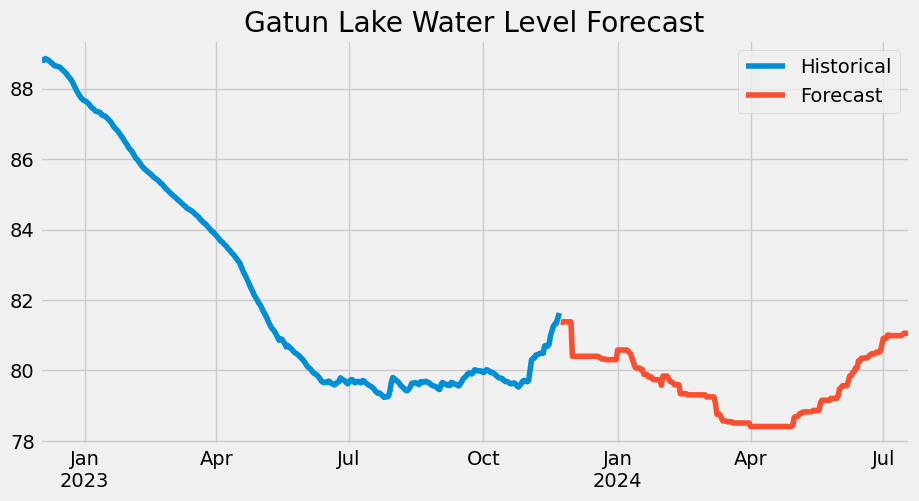

In [56]:
ax = df_and_future.loc['2022-12-01':]['level'].plot();
ax = future_w_features['level'].plot(figsize=(10, 5), 
                                     title='Gatun Lake Water Level Forecast',);

plt.legend(['Historical', 'Forecast'], loc='upper right');

## Train-Test Split Visualization

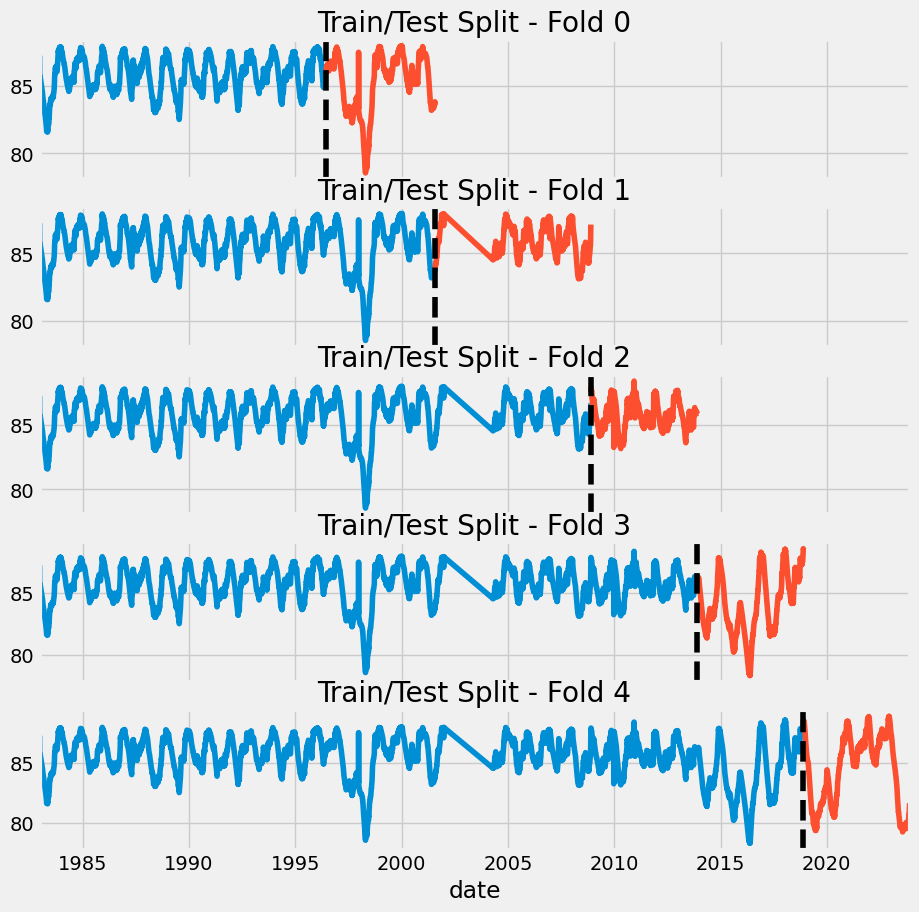

In [57]:
tss = TimeSeriesSplit(n_splits=5, test_size=365 * 5, gap=1)

fig, axs = plt.subplots(5, 1, figsize=(10, 10), sharex=True)

fold = 0 
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train['level'].plot(ax=axs[fold], label='train', title=f'Train/Test Split - Fold {fold}')
    test['level'].plot(ax=axs[fold], label='test', title=f'Train/Test Split - Fold {fold}')
    axs[fold].axvline(test.index.min(), color='black', linestyle='--')

    fold += 1
    
plt.show()